## Read the data

In [1]:
import iris
import numpy
import matplotlib.pyplot as plt
import glob

In [2]:
control_files = glob.glob('/g/data/ua6/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/piControl/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_*.nc')
control_file = '/g/data/ua6/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/piControl/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_000101-001012.nc'
hist_file = '/g/data/ua6/drstree/CMIP5/GCM/CSIRO-QCCCE/CSIRO-Mk3-6-0/historical/mon/ocean/thetao/r1i1p1/thetao_Omon_CSIRO-Mk3-6-0_historical_r1i1p1_185001-185912.nc'
coeff_file = '/g/data/r87/dbi599/thetao-cubic-coefficients_Omon_CSIRO-Mk3-6-0_piControl_r1i1p1_all.nc'
dedrift_file = '/g/data/r87/dbi599/thetao-dedrifted_Omon_CSIRO-Mk3-6-0_historical_r1i1p1_185001-185912.nc'

In [3]:
min_lat, max_lat = [-62.1, -61.9]
lat_subset = lambda cell: min_lat <= cell <= max_lat
lev_constraint = iris.Constraint(depth=15)
lat_constraint = iris.Constraint(latitude=lat_subset)
lon_constraint = iris.Constraint(longitude=101.25)

In [4]:
with iris.FUTURE.context(cell_datetime_objects=True):
    control_cube = iris.load_cube(control_file, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint)
    hist_cube = iris.load_cube(hist_file, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint)
    coeff_a_cube = iris.load_cube(coeff_file, 'coefficient a' & lev_constraint & lat_constraint & lon_constraint)
    coeff_b_cube = iris.load_cube(coeff_file, 'coefficient b' & lev_constraint & lat_constraint & lon_constraint)
    coeff_c_cube = iris.load_cube(coeff_file, 'coefficient c' & lev_constraint & lat_constraint & lon_constraint)
    coeff_d_cube = iris.load_cube(coeff_file, 'coefficient d' & lev_constraint & lat_constraint & lon_constraint)
    dedrift_cube = iris.load_cube(dedrift_file, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint)

/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:794: UserWarning: Missing CF-netCDF measure variable u'areacello', referenced by netCDF variable u'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:794: UserWarning: Missing CF-netCDF measure variable u'volcello', referenced by netCDF variable u'thetao'
  warnings.warn(message % (variable_name, nc_var_name))
/g/data/r87/dbi599/miniconda2/envs/default/lib/python2.7/site-packages/iris/fileformats/cf.py:1139: UserWarning: NetCDF default loading behaviour currently does not expose variables which define reference surfaces for dimensionless vertical coordinates as independent Cubes. This behaviour is deprecated in favour of automatic promotion to Cubes. To switch to the new behaviour, set iris.FUTURE.netcdf_promote to True.
  warnings.warn(msg)


In [5]:
def edit_attributes(cube, field, filename):
    """Remove the attributes that typically differ between files.
    (i.e. these cause iris to throw a ConstraintMismatchError when you try and merge
    cubes arising from different files)  
    """ 
    cube.attributes.pop('creation_date', None)
    cube.attributes.pop('tracking_id', None)
    cube.attributes.pop('history', None)

In [17]:
full_control_cube = iris.load(control_files, 'sea_water_potential_temperature' & lev_constraint & lat_constraint & lon_constraint, callback=edit_attributes)
full_control_cube = full_control_cube.concatenate_cube()

In [18]:
print full_control_cube

sea_water_potential_temperature / (K) (time: 6000)
     Dimension coordinates:
          time                             x
     Scalar coordinates:
          depth: 15.0 m, bound=(10.0, 21.6242351532) m
          latitude: -62.0240516663 degrees, bound=(-62.490436554, -61.5576667786) degrees
          longitude: 101.25 degrees, bound=(100.3125, 102.1875) degrees
     Attributes:
          Conventions: CF-1.4
          associated_files: baseURL: http://cmip-pcmdi.llnl.gov/CMIP5/dataLocation gridspecFile: gridspec_ocean_fx_CSIRO-Mk3-6-0_piControl_r0i0p0.nc...
          branch_time: 0.0
          cmor_version: 2.5.9
          comment: Data is stored on the native ocean T-grid on which the data was generated....
          contact: Project leaders: Stephen Jeffrey (Stephen.Jeffrey@qld.gov.au) & Leon Rotstayn...
          experiment: pre-industrial control
          experiment_id: piControl
          forcing: N/A (Pre-industrial conditions with all forcings fixed at 1850 levels)
          f

## Validate polynomial contruction

In [8]:
def apply_polynomial(x, a, b, c, d):
    """Evaluate cubic polynomial.

    The axis argument is not used but is required for the function to be 
      used with numpy.apply_over_axes 

    """

    result = a + b * x + c * x**2 + d * x**3 
    
    return result 

In [9]:
my_poly = apply_polynomial(full_control_cube.coord('time').points,
                           coeff_a_cube.data,
                           coeff_b_cube.data,
                           coeff_c_cube.data,
                           coeff_d_cube.data)

In [10]:
print my_poly[0:5]

[ 273.03614157  273.03639618  273.03665069  273.03691375  273.03717672]


In [11]:
numpy_poly = numpy.poly1d([float(coeff_d_cube.data), 
                           float(coeff_c_cube.data),
                           float(coeff_b_cube.data),
                           float(coeff_a_cube.data)])

In [12]:
print numpy_poly(full_control_cube.coord('time').points)[0:5]

[ 273.03614157  273.03639618  273.03665069  273.03691375  273.03717672]


In [13]:
print control_cube.data[0:5]

[ 272.67153931  274.03100586  273.52758789  272.86123657  272.12963867]


### Plot

In [14]:
% matplotlib inline

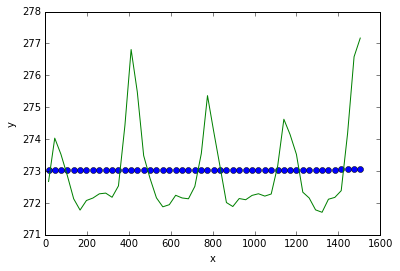

In [15]:
plt.plot(full_control_cube.coord('time').points[0:50], my_poly[0:50], 'o')
plt.plot(control_cube.coord('time').points[0:50], control_cube.data[0:50])
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [25]:
print coeff_a_cube.data

print my_poly[950:960]

273.036007766
[ 273.24665794  273.24684012  273.24702222  273.24720424  273.24738617
  273.24757101  273.24775278  273.24793447  273.24811608  273.2482976 ]


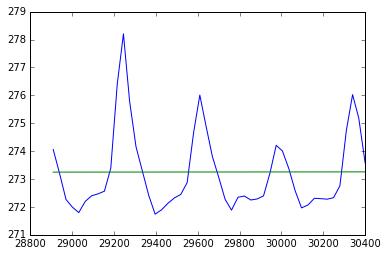

In [28]:
plt.plot(full_control_cube.coord('time').points[950:1000], full_control_cube.data[950:1000], 'b-')
plt.plot(full_control_cube.coord('time').points[950:1000], my_poly[950:1000], 'g-')
plt.show()

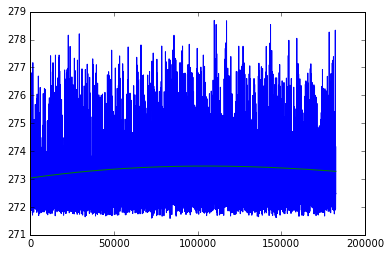

In [29]:
plt.plot(full_control_cube.coord('time').points, full_control_cube.data, 'b-')
plt.plot(full_control_cube.coord('time').points, my_poly, 'g-')
plt.show()

## Validate removal from historical

In [30]:
print hist_cube.coord('time').points[0:5]
print dedrift_cube.coord('time').points[0:5]

[  15.5   45.    74.5  105.   135.5]
[  15.5   45.    74.5  105.   135.5]


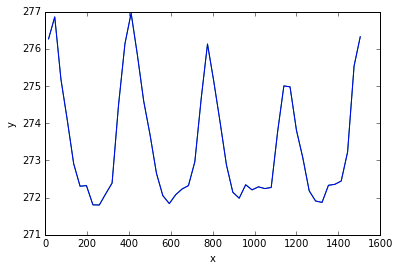

In [31]:
plt.plot(hist_cube.coord('time').points[0:50], hist_cube.data[0:50], 'g-')
plt.plot(dedrift_cube.coord('time').points[0:50], dedrift_cube.data[0:50], 'b-')
plt.ylabel('y')
plt.xlabel('x')
plt.show()

In [32]:
hist_cube.attributes['branch_time']

29200.0

In [33]:
control_time_axis = list(full_control_cube.coord('time').points)
print len(control_time_axis)
print control_time_axis[959:965]
print control_time_axis.index(29184.5)

6000
[29184.5, 29215.5, 29245.0, 29274.5, 29305.0, 29335.5]
959


In [38]:
print hist_cube.data[25]
print dedrift_cube.data[25]
print hist_cube.data[25] - dedrift_cube.data[25]
print my_poly[974] - float(coeff_a_cube.data)
print my_poly[25] - float(coeff_a_cube.data)

276.13
276.127899223
0.0023803182529
0.214988078437
0.00666224736068


So I've got this problem where it seems that the drift removal hasn't worked correctly. The polynomial I've generated seems to be correct, but something when wrong when removing it from the data.